## Part 1: Analyzing the Structural Properties of the NCAA College Football Network

We'll analyze the NCAA College Football Network's structural properties. This includes calculating key network metrics such as network diameter, characteristic path length, average clustering coefficient, transitivity, assortativity, and degree sequence. We'll explore community structures within the network using the Louvain algorithm across different resolutions, comparing these structures to a ground truth and visualizing the network's community divisions. Additionally, this entails calculating and visualizing the inter-community connection density matrix, offering insights into how community structures are interconnected within the network.

## Part 2: Graph Generation and Comparison with the NCAA College Football Network

Part 2 focuses on generating synthetic networks based on the empirical data analyzed in Part 1, utilizing various graph generation models like the Configuration Model and Stochastic Block Model, as well as Hierarchical Random Graphs (HRG) using PyHRG. This section involves creating graphs that mimic the structural properties of the original network, followed by a detailed comparison of the generated networks against the empirical network. Key network statistics are calculated for each generated graph, including network diameter, characteristic path length, average clustering coefficient, transitivity, and assortativity. The generated graphs are then statistically compared to the empirical network to evaluate which graph generation model most accurately reflects the original network's structure.

In [23]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import ttest_1samp

from typing import Tuple, List, Dict, Union

## Part 1: Structural Properties of the Graph

In [24]:
def load_football_graph() -> nx.Graph:    
    G = nx.read_gml("football.gml")
    return G    

In [25]:
def calculate_graph_statistics(G: nx.Graph) -> Dict[str, Union[float, List[int]]]:
    """
    Inputs:
    G: NetworkX graph object
    
    Returns:
    Dictionary of graph statistics
    """
    graph_statistics = {}

    graph_statistics['diameter'] = nx.diameter(G) #graph diameter
    graph_statistics['characteristic_path_length'] = nx.average_shortest_path_length(G) #characteristic path length
    graph_statistics['average_clustering_coefficient'] = nx.average_clustering(G) #average clustering coefficient
    graph_statistics['transitivity'] = nx.transitivity(G) #transitivity
    graph_statistics['assortativity'] = nx.degree_assortativity_coefficient(G) #assortativity
    graph_statistics['degree_sequence'] = [degree for _,degree in G.degree()] #degree sequence

    return graph_statistics

In [26]:
def sweep_louvain_resolutions(G: nx.Graph, min_resolution: int=1, max_resolution: int=10) -> Tuple[List[int], List[float]]:
    """
    Inputs:
    G: NetworkX graph object
    min_resolution : integer
    max_resolution : integer
    
    Returns:
    Tuple of list of resolutions and list of NMIs
    """
    resolutions = list(range(min_resolution, max_resolution + 1))
    nmis = []

    ground_truth = [G.nodes[node]['value'] for node in G.nodes] #extract ground truth communities

    node_to_index = {node: i for i, node in enumerate(G.nodes)} #map each node to integer index

    for resolution in resolutions:
        communities = louvain_communities(G, resolution=resolution)
        community_labels = -1 * np.ones(len(G.nodes)) #initialize community labels array with -1

        for i, community in enumerate(communities):
            for node in community:
                community_labels[node_to_index[node]] = i

        nmi = normalized_mutual_info_score(ground_truth, community_labels)
        nmis.append(nmi)

    return resolutions, nmis


def plot_nmi_vs_resolution(resolutions: List[int], nmis: List[float], save: bool=False) -> None:
    """
    Inputs:
    min_resolution : integer
    max_resolution : integer
    save: boolean
    
    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    plt.plot(resolutions, nmis, marker='o')
    plt.xlabel('Resolution')
    plt.ylabel('Normalized Mutual Information (NMI)')
    plt.title('NMI vs. Resolution in Louvain Community Detection')
    plt.grid(True)

    if save:
        plt.savefig('1_2_1.png')

    plt.show()

In [27]:
def calculate_best_partition(G: nx.Graph, resolutions: List[int], nmis: List[float]) -> Tuple[int, List[str]]:
    """
    Inputs:
    G: NetworkX graph object
    resolutions : a list of integer
    nmis :a list of float
    
    Returns:
    Tuple of resolution and partition
    
    """
    # Find index of the highest NMI
    max_nmi_index = np.argmax(nmis)
    best_resolution = resolutions[max_nmi_index]

    # Calculate the partition with best resolution
    best_partition = louvain_communities(G, resolution=best_resolution)

    return best_resolution, best_partition

def plot_best_partition(G: nx.Graph, partition: List[str], save: bool=False) -> None:
    """
    Inputs:
    G: NetworkX graph object
    partition : List[str]
    save: boolean
    
    Returns:
    None
    
    """
    plt.figure(figsize=(15, 8))  # Increase figure size

    # Ground truth 
    plt.subplot(1, 2, 1)
    ground_truth_colors = [G.nodes[node]['value'] for node in G.nodes]
    pos = nx.spring_layout(G)  
    nx.draw(G, pos, node_color=ground_truth_colors, with_labels=True, node_size=50, font_size=8, width=0.5)
    plt.title('Ground Truth Communities')

    # Best partition 
    plt.subplot(1, 2, 2)
    partition_map = {node: idx for idx, community in enumerate(partition) for node in community}
    partition_colors = [partition_map[node] for node in G.nodes]
    nx.draw(G, pos, node_color=partition_colors, with_labels=True, node_size=50, font_size=8, width=0.5)
    plt.title('Best Partition (Louvain) Communities')

    if save:
        plt.savefig('1_2_2.png')

    plt.show()

In [28]:
def calculate_inter_community_density(G: nx.Graph, partition: list) -> Tuple[np.ndarray, List[int]]:
    """
    Inputs:
    G: NetworkX graph object
    partition : list
    
    Returns:
    Tuple of np array and List[int], intercommunity connection density matrix
    
    """
    num_communities = len(partition)
    p = np.zeros((num_communities, num_communities))
    sizes = [len(community) for community in partition]

    # Create a mapping of node to community index
    node_to_community = {}
    for i, community in enumerate(partition):
        for node in community:
            node_to_community[node] = i

    # Count edges between communities
    for edge in G.edges():
        u, v = edge
        comm_u = node_to_community[u]
        comm_v = node_to_community[v]
        p[comm_u, comm_v] += 1
        if comm_u != comm_v:
            p[comm_v, comm_u] += 1  #if between different communities, count edge in both directions

    # Normalize matrix
    for i in range(num_communities):
        for j in range(num_communities):
            max_edges = sizes[i] * sizes[j]  #this is maximum possible edges between communities i and j
            p[i, j] /= max_edges

    return p, sizes

def plot_p_matrix(p: np.ndarray, save: bool=False):
    """
    Inputs:
    p: np array, intercommunity connection density matrix
    save: boolean
    
    Returns:
    None
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(p, annot=True, cmap='viridis', square=True)
    plt.title('Inter-Community Connection Density Matrix')
    plt.xlabel('Community')
    plt.ylabel('Community')

    if save:
        plt.savefig('1_3.png')

    plt.show()

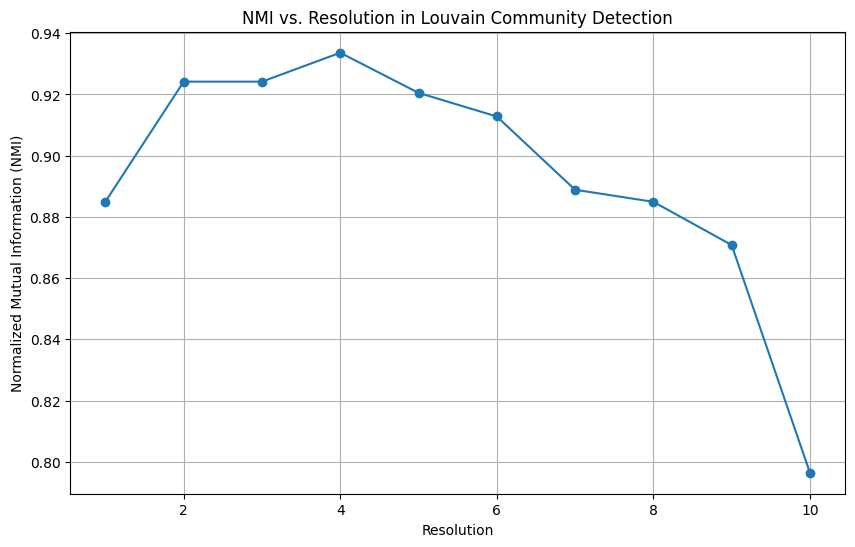

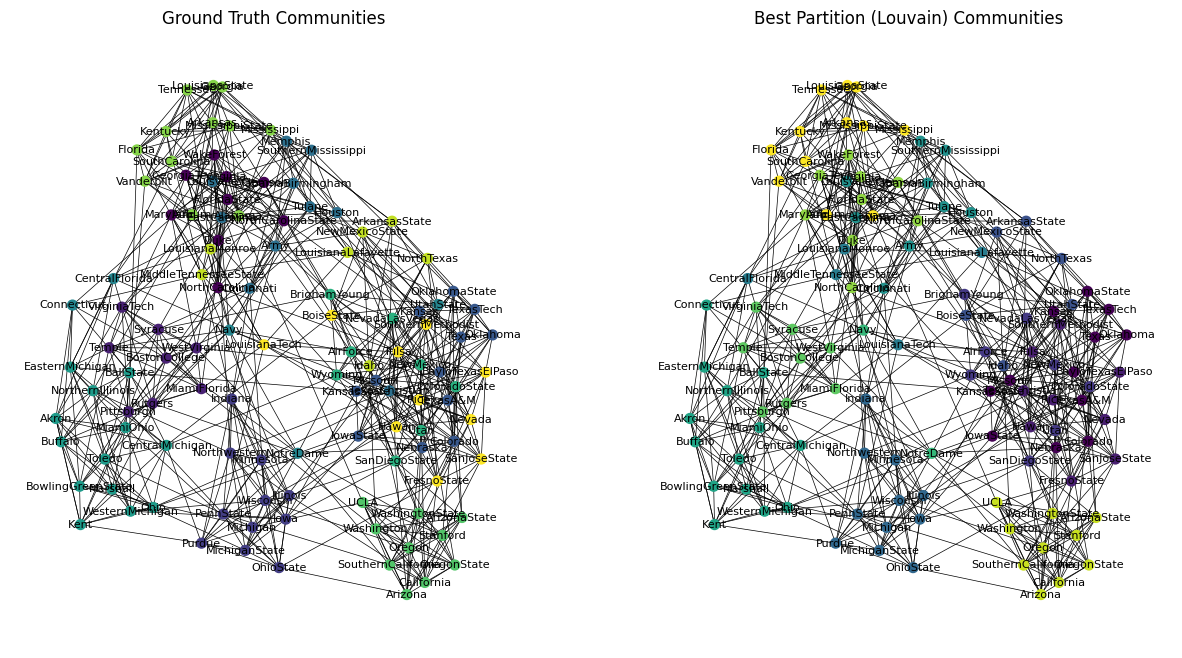

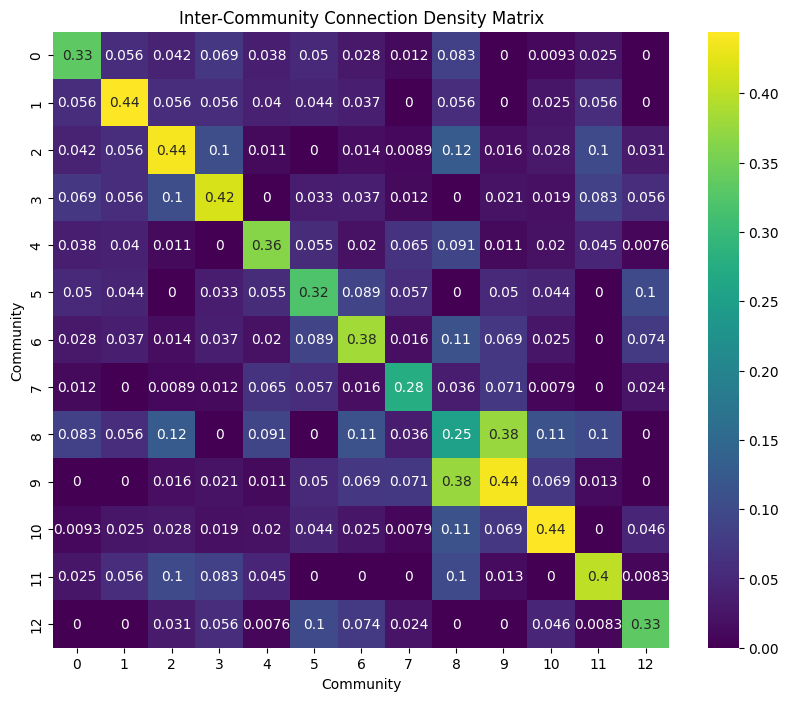

In [29]:
G = load_football_graph()

graph_stats = calculate_graph_statistics(G)

resolutions, nmis = sweep_louvain_resolutions(G)
best_resolution, partition = calculate_best_partition(G, resolutions, nmis)
plot_nmi_vs_resolution(resolutions, nmis)
plot_best_partition(G, partition)

p, sizes = calculate_inter_community_density(G, partition)
plot_p_matrix(p)

### Part 1 Synopsis

Once we get to resolution 2, the NMI decreases as we increase the resolution. This may be because as the resolution increases, the algorithm may be dividing what should be considered a single community into smaller finely-tuned communities. So, the ground truth may be closer to 2 communities. 

The best resolution is 2 with an NMI of 0.924. This is close to 1, so it suggests a strong similarity between the partition and the ground truth. 

## Part 2: Graph Generators

In [30]:
def generate_configuration_graphs(degree_sequence: List[int], n_graphs: int=100) -> List[nx.Graph]:
    """
    Inputs:
    degree_sequence: List[int]
    n_graphs: int
    
    Returns:
    a list of graph
    """
    graphs = []
    for _ in range(n_graphs):
        # Generate a graph using the Configuration Model
        # create_using parameter to ensures graph, not multigraph
        random_graph = nx.configuration_model(degree_sequence, create_using=nx.Graph())
        # Remove self-loops and parallel edges
        random_graph = nx.Graph(random_graph)  #removes parallel edges and self loops
        graphs.append(random_graph)

    return graphs

def generate_sbm_graphs(p: np.ndarray, sizes: List[int], n_graphs: int=100) -> List[nx.Graph]:
    """
    Inputs:
    p: np.ndarray, element (r,s) gives the density of edges going from the nodes of group r to nodes of group s.
    degree_sequence: List[int]
    n_graphs: int
    
    Returns:
    a list of graph
    """
    graphs = []
    for _ in range(n_graphs):
        random_graph = nx.stochastic_block_model(sizes, p) #generate a graph using the Stochastic Block Model
        graphs.append(random_graph)

    return graphs


In [31]:
def calculate_edge_probability(dendrogram: nx.DiGraph) -> Dict[str, Dict[str, float]]:
    """
    Inputs:
    dendrogram: NetworkX graph object    
    
    Returns:
    a dictionary of edge probabilities between all pairs of leaf nodes.
    """
    edge_probs = {}

    def calculate_probs(node):
        if dendrogram.out_degree(node) == 0:  # Leaf node
            return {node: 1.0}
        
        left, right = dendrogram.nodes[node]['left'], dendrogram.nodes[node]['right']
        p = dendrogram.nodes[node]['p']
        left_probs = calculate_probs(left)
        right_probs = calculate_probs(right)

        for l_node, l_prob in left_probs.items():
            for r_node, r_prob in right_probs.items():
                if l_node not in edge_probs:
                    edge_probs[l_node] = {}
                if r_node not in edge_probs:
                    edge_probs[r_node] = {}
                edge_probs[l_node][r_node] = p * l_prob * r_prob
                edge_probs[r_node][l_node] = p * l_prob * r_prob

        # Merge dictionaries
        merged_probs = left_probs.copy()
        for key, value in right_probs.items():
            merged_probs[key] = value

        return merged_probs

    calculate_probs(list(dendrogram.nodes)[0])  #assume root node is first one?
    return edge_probs

def generate_graph_from_prob(edge_probs: Dict[str, Dict[str, float]]) -> nx.Graph:
    """
    Inputs:
    edge_probs: a dictionary of edge probabilities between all pairs of leaf nodes.
    
    Returns:
    H: NetworkX graph object
    """
    H = nx.Graph()
    for node in edge_probs:
        H.add_node(node)
        for neighbor, prob in edge_probs[node].items():
            if random.random() < prob:
                H.add_edge(node, neighbor)

    return H

def generate_hrg_graphs(edge_probs: Dict[str, Dict[str, float]], n_graphs: int=100) -> List[nx.Graph]:
    """
    Inputs:
    edge_probs: a dictionary of edge probabilities between all pairs of leaf nodes.
    n_graphs: int
    
    Returns:
    a list of NetworkX graph object
    """
    graphs = [generate_graph_from_prob(edge_probs) for _ in range(n_graphs)]
    return graphs

In [32]:
def calculate_generated_statistics(graphs: List[nx.Graph]) -> Dict[str, list]:
    """
    Inputs:
    graphs: a list of NetworkX graph object
    
    Returns:
    a dictionary of graph statistics
    """
    diameters, cpls, clustering_coeffs, transitivities, assortativities = [], [], [], [], []

    for G in graphs:
        
        if not nx.is_connected(G):#consider only the largest connected component to safely calculate metrics without None, inf
            G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

        diameters.append(nx.diameter(G)) #diameter
        cpls.append(nx.average_shortest_path_length(G)) #CPL
        clustering_coeffs.append(nx.average_clustering(G)) #average clustering coefficient
        transitivities.append(nx.transitivity(G)) #transitivity
        assortativities.append(nx.degree_assortativity_coefficient(G)) #assortativity

    return {
        "diameter": diameters,
        "characteristic_path_length": cpls,
        "average_clustering_coefficient": clustering_coeffs,
        "transitivity": transitivities,
        "assortativity": assortativities
    }

def compare_generated_to_ground_truth(ground_truth_features: Dict[str, float], generated_features: Dict[str, List[float]]) -> Dict[str, float]:
    """
    Inputs:
    ground_truth_features: a dictionary of graph statistics
    generated_features: a dictionary of graph statistics
    
    Returns:
    a dictionary of one-sample t-test
    """
    p_vals = {}

    for feature in generated_features:
        # One-sample t-test for each feature
        t_stat, p_val = ttest_1samp(generated_features[feature], ground_truth_features[feature])
        p_vals[feature] = p_val

    return p_vals

def plot_graph_statistics(graph_statistics: List[Dict[str, list]], save: bool=False) -> None:
    """
    Inputs:
    graph_statistics: a dictionary of graph statistics
    
    Returns:
    None
    """
    plt.figure(figsize=(15, 6))
    properties = ["diameter", "characteristic_path_length", "average_clustering_coefficient", "transitivity", "assortativity"]
    
    for i, prop in enumerate(properties):
        plt.subplot(1, 5, i + 1)
        data = [stats[prop] for stats in graph_statistics]
        plt.boxplot(data, labels = ['Empirical', 'Configuration', 'Stochastic Block', 'Hierarchical Random'])
        plt.xticks(rotation=45)
        plt.title(prop)
        plt.ylabel('Graph Metric Value')
        plt.tight_layout()

    if save:
        plt.savefig('2_3.png')

    plt.show()

Configuration Model t-test
{'diameter': 1.4834474934508404e-09, 'characteristic_path_length': 8.172852502081474e-135, 'average_clustering_coefficient': 2.947594667146495e-178, 'transitivity': 8.1612013086692e-179, 'assortativity': 8.80367812477751e-59}
Stochastic Block Model t-test
{'diameter': 4.3485635983128966e-49, 'characteristic_path_length': 2.1538876291444092e-72, 'average_clustering_coefficient': 2.449893656313055e-117, 'transitivity': 2.289107421265606e-127, 'assortativity': 8.432833302705552e-59}
HRG Model t-test
{'diameter': 2.339325484565474e-20, 'characteristic_path_length': 6.584422928703978e-125, 'average_clustering_coefficient': 2.275892258920127e-74, 'transitivity': 2.9646659607478843e-95, 'assortativity': 1.142780238136589e-52}


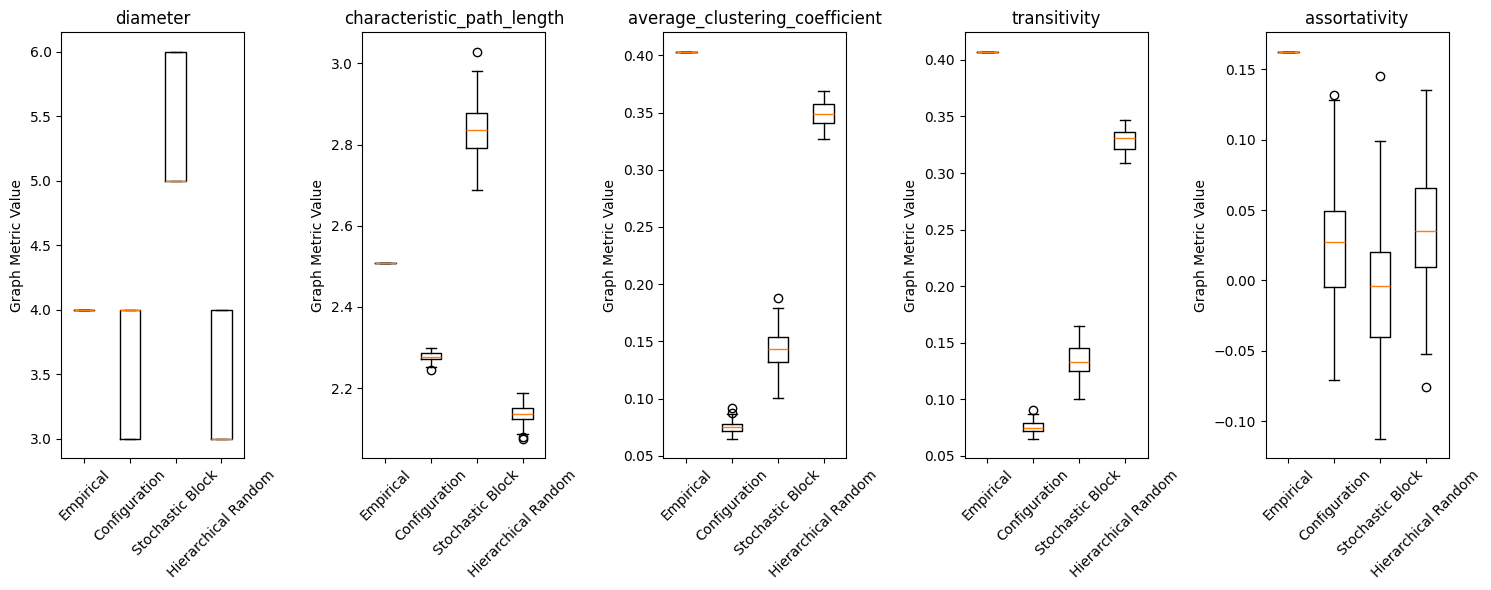

In [33]:
G = load_football_graph()
graph_stats = calculate_graph_statistics(G)

# Configuration Model
config_graphs = generate_configuration_graphs(graph_stats['degree_sequence'])

# Stochastic Block Model
resolutions, nmis = sweep_louvain_resolutions(G)
best_resolution, partition = calculate_best_partition(G, resolutions, nmis)
p, sizes = calculate_inter_community_density(G, partition)
sbm_graphs = generate_sbm_graphs(p, sizes)

# Hierarchical Random Graph Model
dendrogram = nx.read_gml("football-hrg.gml")
edge_probs = calculate_edge_probability(dendrogram)
hrg_graphs = generate_hrg_graphs(edge_probs)

# Calculating network characteristic statistics
config_stats = calculate_generated_statistics(config_graphs)
sbm_stats = calculate_generated_statistics(sbm_graphs)
hrg_stats = calculate_generated_statistics(hrg_graphs)

# Hypothesis Test Stats
print('Configuration Model t-test')
print(compare_generated_to_ground_truth(graph_stats, config_stats))

print('Stochastic Block Model t-test')
print(compare_generated_to_ground_truth(graph_stats, sbm_stats))

print('HRG Model t-test')
print(compare_generated_to_ground_truth(graph_stats, hrg_stats))

plot_graph_statistics([graph_stats, config_stats, sbm_stats, hrg_stats])

### Part 2 Synopsis

The statistics are all pretty different across every graph metric, with the exception of maybe assortativity. For each graph generator the median value, spread, and values of the spread are not very similar. I am looking at diameter and CPL for looking at path properties. The configuration generator seems to best capture path-like elements, while the stochastic block seems the worst. The average clustering coefficient and transitivity tell us about how liley nodes in a network are to cluster together. The hierarchical random generator is the most similar to the ground truth on both these fronts. Assortativity tells us about node connectivity due to some sort of similarity; the results across the three generators are similar with Hierarchical Random marginally better. 

The Configuration generator randomly rewires edges with degree distribution preservation. It lacks on preserving higher order structures like community and clustering. This may explain why it is similar to the empirical graph for diameter and CPL, but not average clustering coefficient and transitivity. The Stochastic Block generator makes defined community structures, but may not preserve degree distribution very well. This may explain why the diameter and CPL are the least similar to the empirical of the three generators. The Hierarchical Random generator models a network as a hierarchy of communities, which can capture communities along with how communities are connected, so it can sometimes we better with complex networks. The Hierarchical Random generator is significantly lower than the empirical in CPL, this might be because it is trying to link high-level hierarchies at far away nodes. Overall, the Hierarchical Random seems like the best generator. 